In [3]:
import timm
deit = timm.create_model('deit_base_patch16_224', pretrained=True)

/Users/alessandroardenghi/anaconda3/envs/jigsaw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
import torch.nn as nn
import timm

class MultiTaskLearner(nn.Module):
    def __init__(self, pretrained_deit, custom_pos_embed):
        super().__init__()
        self.patch_embed = pretrained_deit.patch_embed
        self.cls_token = pretrained_deit.cls_token
        self.pos_embed = nn.Parameter(custom_pos_embed)
        self.pos_drop = pretrained_deit.pos_drop
        self.blocks = pretrained_deit.blocks
        self.norm = pretrained_deit.norm
        

In [8]:
import torch
import torch.nn as nn
import timm

class DeiTEncoder(nn.Module):
    def __init__(self, pretrained_deit, pos_embed_intra_jigsaw, pos_embed_inter_jigsaw):
        super().__init__()
        self.patch_embed = pretrained_deit.patch_embed
        self.cls_token = pretrained_deit.cls_token
        self.pos_embed_intra_jigsaw = nn.Parameter(pos_embed_intra_jigsaw)
        self.pos_embed_inter_jigsaw = nn.Parameter(pos_embed_inter_jigsaw)
        self.pos_drop = pretrained_deit.pos_drop
        self.blocks = pretrained_deit.blocks
        self.norm = pretrained_deit.norm

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # prepend [CLS]
        x = x + self.pos_embed_intra_jigsaw
        x = x + self.pos_embed_inter_jigsaw
        x = self.pos_drop(x)

        features = []
        for blk in self.blocks:
            x = blk(x)
            features.append(x) 

        x = self.norm(x)
        return x, features

In [9]:
class DeiTClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        embed_dim = encoder.cls_token.shape[-1]
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x, _ = self.encoder(x)
        cls_output = x[:, 0]  # [CLS] token
        return self.head(cls_output)

In [11]:
pretrained_pos_embed = deit.pos_embed  # nn.Parameter
pos_embed_tensor = pretrained_pos_embed.detach().clone()

pos_embed_wo_cls = pos_embed_tensor[:, 1:, :]

In [23]:
pos_embed_tensor.shape

torch.Size([1, 197, 768])

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def visualize_positional_embedding_correlation(pos_embed, title="Positional Embedding Correlation"):
    """
    Visualizes cosine similarity between positional embeddings.
    
    Args:
        pos_embed (torch.Tensor): shape (1, N, D) or (N, D), where N = num positions, D = dim
        title (str): Title of the plot
    """
    # Remove batch dimension if present
    if pos_embed.dim() == 3:
        pos_embed = pos_embed.squeeze(0)  # (N, D)
    
    pos_embed_np = pos_embed.detach().cpu().numpy()  # (N, D)

    # Compute cosine similarity between all positions
    similarity = cosine_similarity(pos_embed_np)  # (N, N)
    print(similarity.shape)
    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Position Index")
    plt.ylabel("Position Index")
    plt.tight_layout()
    plt.show()

(197, 197)


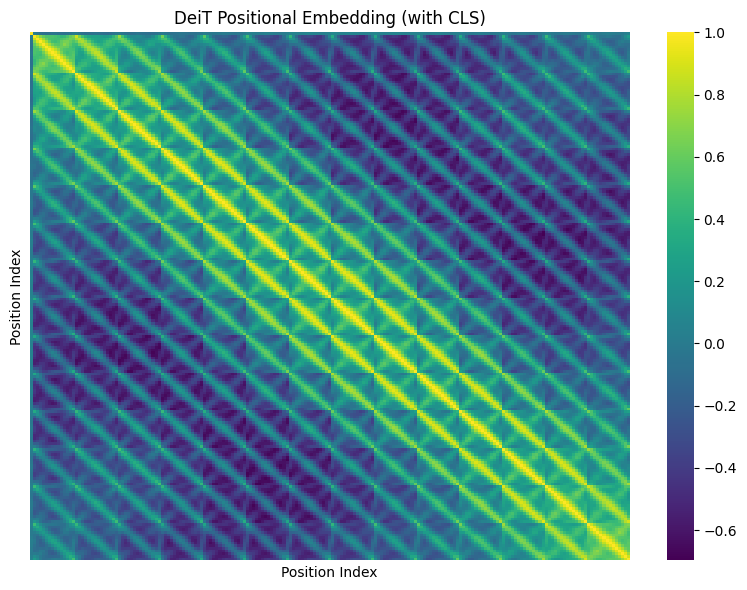

In [25]:
visualize_positional_embedding_correlation(pos_embed_tensor, title="DeiT Positional Embedding (with CLS)")